## Analiza eksploracyjna i inżynieria cech

Jakub Próchnicki

In [57]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from skimage import io
import skimage.filters as sif
import skimage.feature as sft
import skimage.color as sic
import skimage.io as io
import skimage.exposure as ex
import cv2
import skimage.segmentation as sis
import skimage.measure as sime
import skimage.morphology as simo
import os
#-------------------------------------s-------------
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn import svm
import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

In [58]:
path=''
if 'PR_LOCAL' not in os.environ:
  import kagglehub
  path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
else:
  path='.'

In [59]:
def showhist(image,*args, **kwargs):
    title=kwargs.get('title',None)
    plt.figure(figsize=(10,5), dpi= 80)
    plt.axis("off")
    if title!= None :
        plt.title(title)
    
    plt.subplot(1,2,1)
    show(image)
    plt.axis("on")
    plt.subplot(1,2,2)
    if image.ndim == 3:
        color = ('b','g','r')
        for i,col in enumerate(color):
            plt.hist(image[:,:,i].ravel(), bins = 256, color = col)
            plt.xlim([0,256])
        
    else:
        histr = np.histogram(image, bins = 256)
        plt.hist(image.ravel(), bins = 256)
        plt.xlim([0,256])
        
    
    plt.show()
def show(im, tytul = "", axes = False):
    if not(axes):
        plt.axis("off")
    if im.ndim == 2:
        plt.imshow(im,cmap='gray')
    else:
        plt.imshow(im)
    plt.title(tytul)

def load_and_prepare(path):
  img=io.imread(path)
  img=cv2.resize(img, (256, 256))
  if len(img.shape)==3:
    if img.shape[-1]==4:
      img=img[:,:,0:3]
    img=sic.rgb2gray(img)*255
  return img

In [60]:

files =[]
import os
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        files.append(os.path.join(dirname, filename))

In [61]:
train_path=path+'/Training'
test_path=path+'/Testing'

train_data = []
labels=os.listdir(train_path)
df_train=pd.DataFrame()
for label in labels:
  for dir,_,filenames in os.walk(train_path+f'/{label}'):
    tmp=pd.DataFrame(filenames,columns=["path"])
    tmp["tumor"]=label
    tmp["path"]=tmp["path"].map(lambda x:train_path+f'/{label}'+f'/{x}')
    df_train=pd.concat([df_train,tmp],axis=0)


df_test=pd.DataFrame()
for label in labels:
  for dir,_,filenames in os.walk(test_path+f'/{label}'):
    tmp=pd.DataFrame(filenames,columns=["path"])
    tmp["tumor"]=label
    tmp["path"]=tmp["path"].map(lambda x:test_path+f'/{label}'+f'/{x}')
    df_test=pd.concat([df_test,tmp],axis=0)

#print(df_test)
df_all=pd.concat([df_train,df_test],axis=0)
#print(df_all)

Text(0.5, 1.0, 'Łącznie')

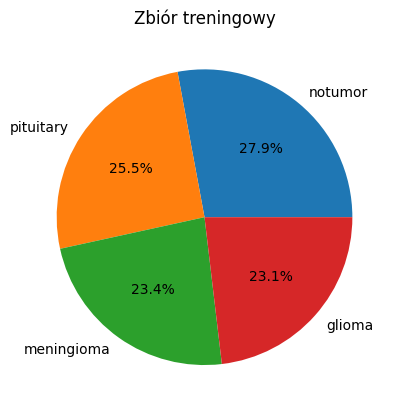

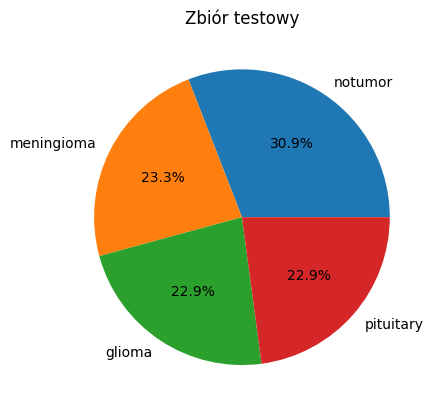

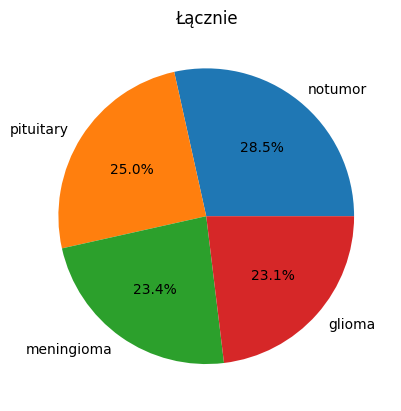

In [62]:
tumor_counts_tr=df_train["tumor"].value_counts()
plt.pie(tumor_counts_tr,labels=tumor_counts_tr.index,autopct='%1.1f%%')
plt.title("Zbiór treningowy")
plt.figure()
tumor_counts_tst=df_test["tumor"].value_counts()
plt.pie(tumor_counts_tst,labels=tumor_counts_tst.index,autopct='%1.1f%%')
plt.title("Zbiór testowy")
plt.figure()
tumor_counts_all=df_all["tumor"].value_counts()
plt.pie(tumor_counts_all,labels=tumor_counts_all.index,autopct='%1.1f%%')
plt.title("Łącznie")

Rozkład przypadków między klasami jest mocno zbliżony do siebie. Żadna klasa nie dominuje w wyraźny sposób. W każdym z zaprezentowanych tu ujęć największy udział przypada na przypadki zdrowe, lecz ich różnica w liczności względem innych klas w żaden sposób nie zaburza rozkładu. Trudno stwierdzić czy taki rozkład odpowiada statystykom stawianych diagnoz, gdyż wymagałoby to szerszej wiedzy z dziedziny jaką reprezentują analizowane tu dane.

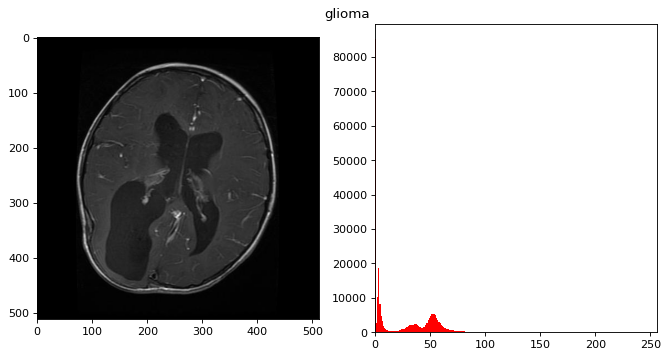

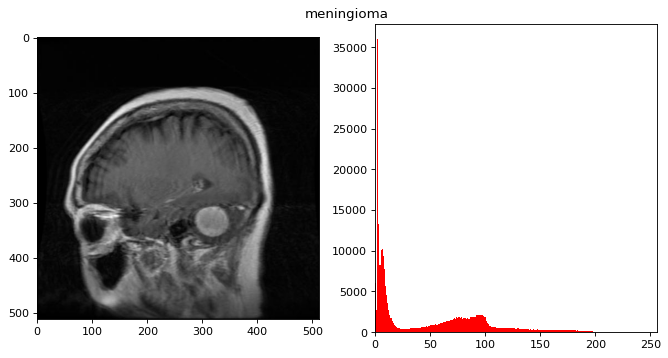

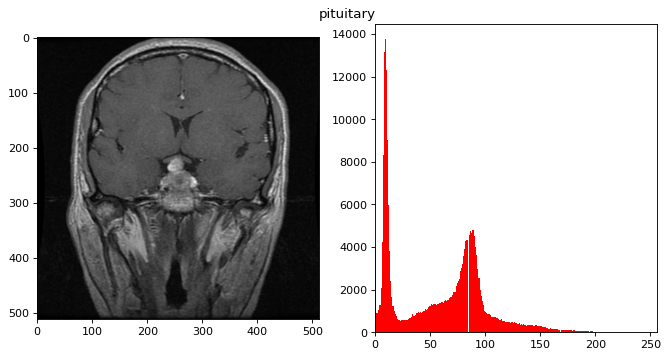

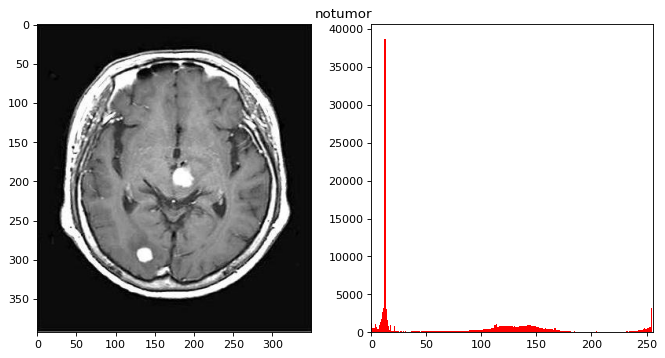

In [63]:
img = io.imread(df_train[df_train["tumor"]=='glioma']["path"][10])
showhist(img,title='glioma')
img = io.imread(df_train[df_train["tumor"]=='meningioma']["path"][10])
showhist(img,title='meningioma')
img = io.imread(df_train[df_train["tumor"]=='pituitary']["path"][10])
showhist(img,title='pituitary')
img = io.imread(df_train[df_train["tumor"]=='notumor']["path"][98])
showhist(img,title='notumor')

Analizując histogramy arbitralnie wybranych zdjęć z poszczególnych kategorii można zaobserwować znaczące różnice w zakresie i ukształtowaniu histogramu. Natomiast dla przedstawicieli wszystkich kategorii można mówić o bardziej lub mniej zauważalnej bimodalności rozkładu. Pierwszy najwyższy prążek najprawdopodobniej odzwierciedla udział tła w obrazie ze względu na jego usytuowanie bliskie czerni. Drugi prążek prawdopodobnie opisuje przekrój głowy, a w szczególności korę mózgową, której udział zazwyczaj stanowi większość w obrazie czaszki oraz która charaktreyzuje się jednolitością barwy w porównaniu do innych obszarów czaszki. Na przykład na zdjęciu 3 (pituitary) o ile w obrazie czaszki kora mózgowa nie dominuje tak bardzo jak w ujęciach robionych "od góry", o tyle pozostała część czaszki jest poprzeplatana różnymi ciemniejszymi i jaśniejszymi obszarami , w związku z czym tak przemieszany obszar raczej nie tworzy drugiego prążka na wykresie, musi to być stosunkowo liczny i zwarty pod względem koloru fragment. Na niektórych obrazach można zaobserwować również znaczny udział bieli w postaci trzeciego prążka usytuowanego na prawym krańcu histogramu.

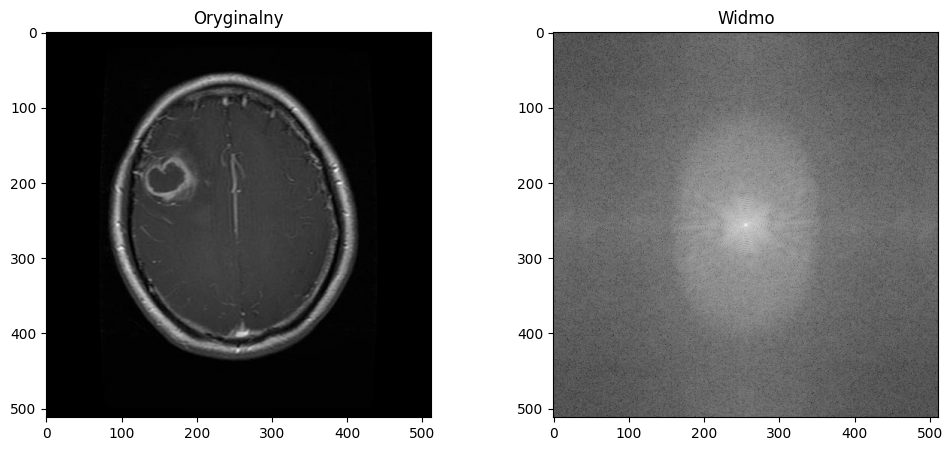

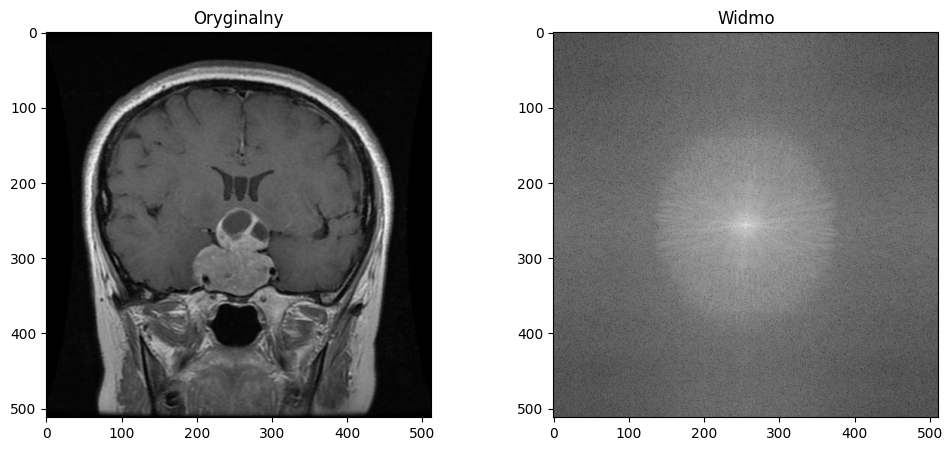

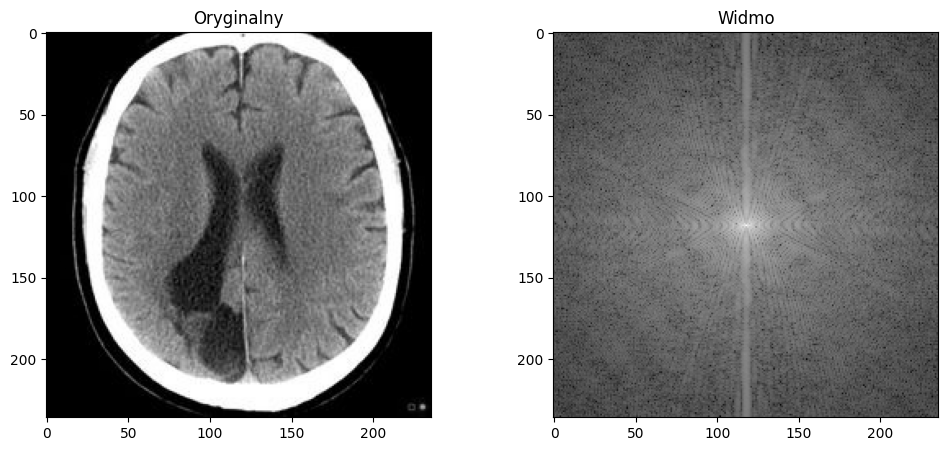

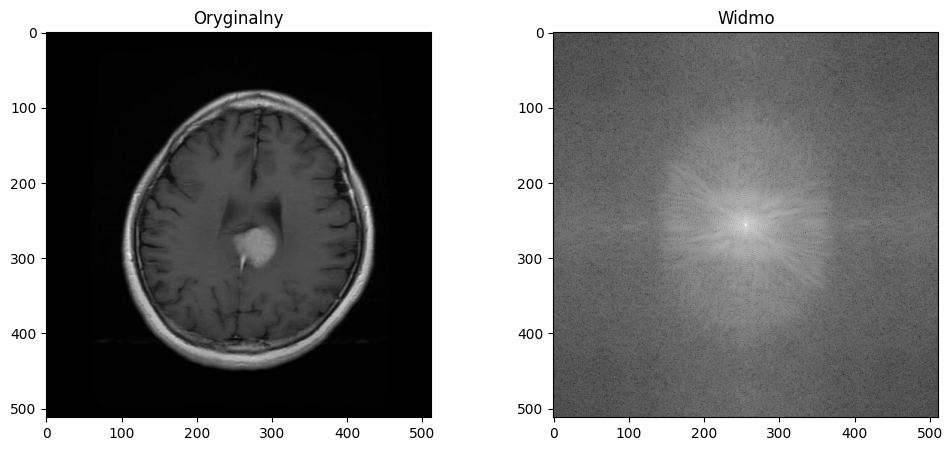

In [65]:
def show_magnitude(img):
    if len(img.shape) ==3 :
        img=sic.rgb2gray(img)
    dft = np.fft.fft2(img)
    dft_shift = np.fft.fftshift(dft)
    magnitude_spectrum = 20 * np.log(np.abs(dft_shift))
    fig=plt.figure(figsize=(12,5))
    plt.subplot(121)
    plt.imshow(img,cmap='gray')
    plt.title('Oryginalny')
    plt.subplot(122)
    plt.imshow(magnitude_spectrum,cmap='gray')
    plt.title('Widmo')
    #print(np.mean(np.where(magnitude_spectrum>=0,magnitude_spectrum,0)))

image=io.imread(f'{path}/Testing/glioma/Te-gl_0025.jpg')
show_magnitude(image)
image=io.imread(f'{path}/Training/pituitary/Tr-pi_0014.jpg')
show_magnitude(image)
image = io.imread(f'{path}/Training/notumor/Tr-no_0054.jpg')
show_magnitude(image)
image = io.imread(f'{path}/Training/meningioma/Tr-me_0054.jpg')
show_magnitude(image)

Analiza arbitralnie wybranych przedstawicieli każdej z kategorii w dziedzinie częstotliwościowej z użyciem dyskretnej transformaty Fouriera daje różne widma. W jednych prążek główny otoczony jest eliptyczną oraz zbliżoną pod względem częstotliwościowym poświatą innych harmonicznych podczas gdy np. na obrazie 3 układa się to w charakterystyczne paski. Myślę, że widmo tych obrazów można interpretować jako miarę ich dynamiki. Niskie pod względem częstotliowści harmoniczne, zaznaczone jasnym odcieniem na obrazie widma, odpowiadają za jednolite pod względem jasności i koloru obszary. Wyższe harmoniczne, czyli ciemniejsze punkty widma, opisują gwałtowne przejścia pomiędzy kolorami jak np. krawędzie. 

In [66]:

def mean_th(path):
  img=load_and_prepare(path)
  result=sif.threshold_mean(img)
  return result
df_train["threshold0"]=df_train["path"].map(mean_th)
df_test["threshold0"]=df_test["path"].map(mean_th)

In [67]:
print(df_train.groupby("tumor")["threshold0"].mean())
print(df_train.groupby("tumor")["threshold0"].std())

tumor
glioma        32.807474
meningioma    43.569319
notumor       60.642211
pituitary     49.389522
Name: threshold0, dtype: float64
tumor
glioma         8.582574
meningioma    14.268996
notumor       21.234284
pituitary      8.220849
Name: threshold0, dtype: float64


<Axes: xlabel='threshold0', ylabel='Count'>

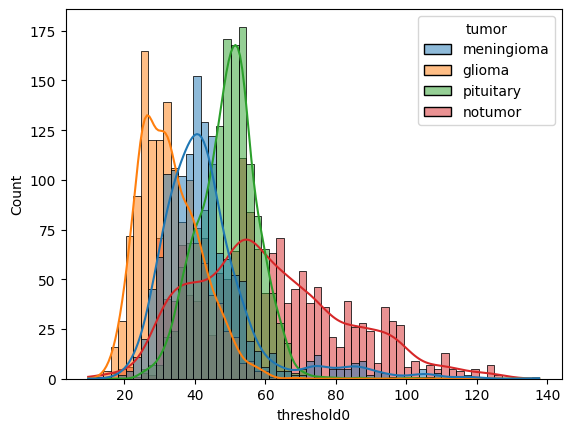

In [68]:
sns.histplot(data=df_train, x="threshold0",hue="tumor", kde=True)

Traktując próg mean jako wypadkową histogramu można przyjąć go za cechę. Niestety nie pozwala on na jednoznaczną identyfikację klas, lecz rozrzut tak przyjętej cechy nie jest na tyle mały, aby ta cecha się nie liczyła w pewnych obszarach klasyfikacji po dodaniu kilku dodatkowych wymiarów. Mam tu na myśli głównie to, że taka cecha może wspomagać testy w drzewie decyzyjnym, lub co trudniej zwizualizować po dodaniu kilku dodatkowych wymiarów klasy mogą już na siebie nie nachodzić.

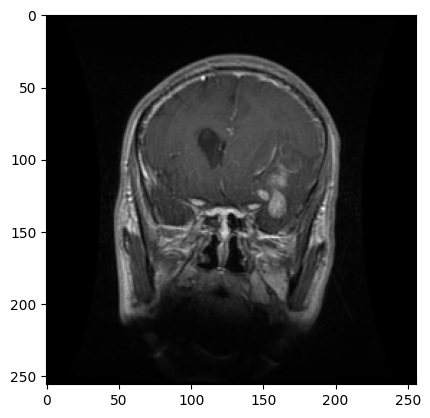

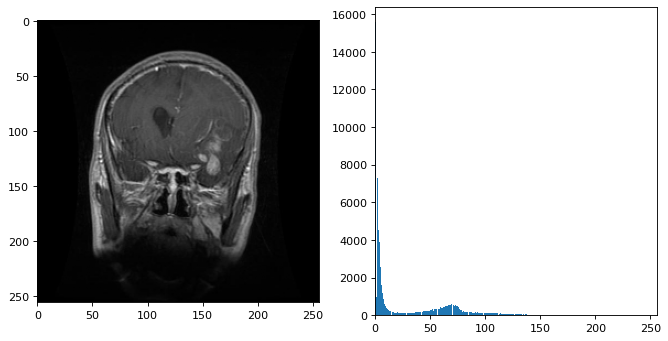

Liczba cech: 282


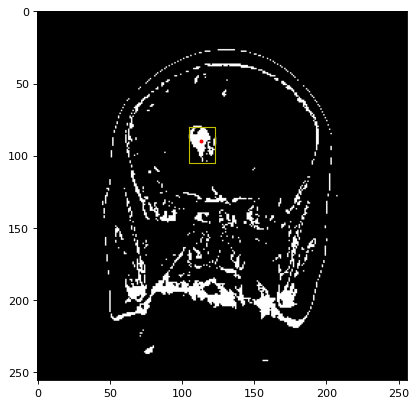

In [69]:
img=load_and_prepare(df_test[df_test["tumor"]=='glioma']["path"][81])


thresholded=np.logical_and(img>20,img<45)
blobs=sft.blob_doh(thresholded)

blobs=[x for x in blobs if x[2]>18]

for blob in blobs:
    y, x, area = blob
    #plt.plot(x, y, '.r', markersize=5)

plt.imshow(img,cmap='gray')
showhist(img)



etykiety = sime.label(thresholded)
cechy = sime.regionprops(etykiety)
print("Liczba cech:",len(cechy))
cechy= [x for x in cechy if x.area>200 and x.area<250]

plt.figure(figsize=(6,6), dpi = 80)
plt.imshow(thresholded, cmap=plt.cm.gray)
for obiekt in cechy:
    y0, x0 = obiekt.centroid
    plt.plot(x0, y0, '.r', markersize=5)
    minr, minc, maxr, maxc = obiekt.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    plt.plot(bx, by, '-y', linewidth=1)



Ciemna zmiana na obrazie mózgu może odpowiadać zdiagnozowanemu guzowi. Cennymi cechami mogłyby być położenie takiej zmiany, jej barwa oraz wielkość. Nawet sama informacja o obecności takiego obszaru mogłaby pomóc stworzyć w drzewie decyzyjnym test (niedoskonały, pewnie obarczony pewnym błędem) pozwalającym identyfikować obrazy zdrowe i poddawać bardziej szczegółowym testom obrazy chore. Niestety zalgorytmizowanie ekstrakcji tych cech jest poważnym utrudnieniem. Po pierwsze ciężko ustalić wartość progu dolnego i górnego obszaru histogramu, w którym należy jej poszukiwać. Jest on dość zmienny jak zostało pokazane to wcześniej. Po drugie jak widać powyżej nawet po odnalezieniu tych granic liczba znalezionych cech jest rzedu klikuset. Nie do końca znany jest też rozmiar poszukiwanego w ten sposób elementu obrazu.

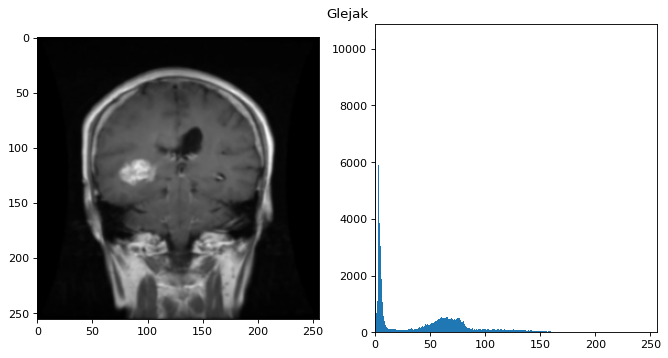

/tmp/ipykernel_9139/1737738246.py:23: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(double_threshold,cmap='gray')


Kurtoza 1.7686520051228785


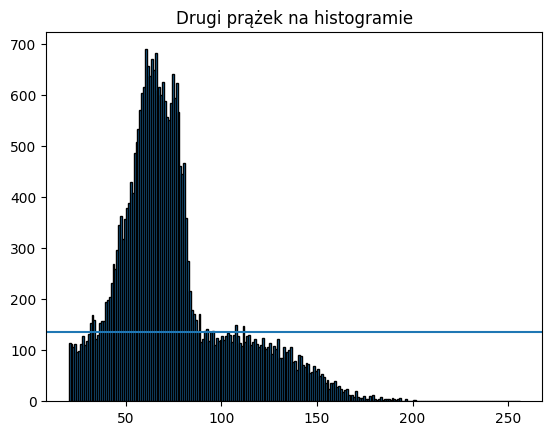

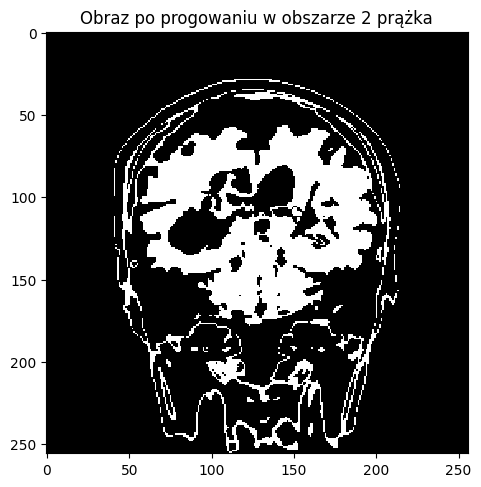

In [70]:
from scipy.signal import find_peaks
from scipy.stats import kurtosis,skew
img = load_and_prepare(df_train[df_train["tumor"]=='glioma']["path"][15])
img=sif.gaussian(img,preserve_range=True)

showhist(img,title="Glejak")
flaten=img.flatten()
hist, bin_edges = np.histogram(flaten, bins=256, range=(0, 256))
hist=hist[20:]
bin_edges=bin_edges[20:]
avg=np.mean(hist)
peaks,_ =find_peaks(hist,height=avg)
plt.bar(bin_edges[:-1], hist, width=1, edgecolor="black", align="edge")


plt.axhline(avg,label='avg')
plt.title("Drugi prążek na histogramie")

plt.figure()
img=load_and_prepare(df_train[df_train["tumor"]=='glioma']["path"][15])
img=sif.gaussian(img,preserve_range=True)
double_threshold = np.logical_and(img > 60, img <80)
io.imshow(double_threshold,cmap='gray')
plt.title('Obraz po progowaniu w obszarze 2 prążka')
print('Kurtoza',kurtosis(hist))

Po progowaniu obrazu zarówno z użyciem ograniczenia górnego jak i dolnego przyjętego jako początek i koniec drugiego prążka na histogramie, można zauważyć, że rzeczywiście w dużej mierze odpowiada za opis mózgu na zdjęciach. Na powyższym obrazie najwięcej obszaru bieli przypada właśnie na mózg. W ekstrackji cech chciałbym się bliżej przyjrzeć temu drugiemu prążkowi. Biorąc pod uwagę analizowany tu obraz można zauważyć, że w obszarze mózgu znajduje się jasna oraz ciemna plama kontrastujące z szarymi komórkami. Jeśli, któraś z nich jest zdiagnozowanym guzem, to z pewnością jej obecność zaburzyła część histogramu opisującą mózg, w porównaniu gdyby nie było tam żadnej z nich. Tak więc kształt durgiego prążka może wiele mówić o obecności takich potencjalnych guzów. Chciałbym go uwzględnić w ekstrakcji cech. Postanowiłem tutaj przyjąć do jego opisu: wartość szczytową, argument dla wartości szczytowej (czyli kolor) oraz inspirując się współczynnikiem kształtu służącym np. do opisu odkształceń sygnałów w elektrotechnice obliczyć taki współczynnik dla obszaru tego prążka. Współczynnik ten to nic innego jak stosunek wartości RMS do wartości średniej. Poza tym z histogramu chciałbym również ująć wartość szczytową pierwszego prążka, która z reguły powinna być odwrotnie proporcjonalna do wielkości czaszki (im więcej tła tym mniejszy obiekt na obrazie) oraz wartość sczytową trzeciego prążka (o ile w ogóle występuje na histogramie), czyli udział bieli.

In [71]:
def get_magnitude_avg(img):
  epsilon = 1e-10
  dft = np.fft.fft2(img)
  dft_shift = np.fft.fftshift(dft)
  fft_abs=np.abs(dft_shift)
  magnitude_spectrum = 20 * np.log(fft_abs+epsilon)
  return np.mean(magnitude_spectrum) 

def extract_features(img_path):
  img = load_and_prepare(img_path)
  magnitude_avg=get_magnitude_avg(img)
  mean_thres=sif.threshold_mean(img)
  img=sif.gaussian(img,preserve_range=True)
  flaten=img.flatten()
  hist, bin_edges = np.histogram(flaten, bins=256, range=(0, 256))
  black_part=hist[0:20]
  white_part=hist[235:]
  main_part=hist[20:235]
  rms=np.sqrt(np.mean(main_part**2))
  avg=np.mean(main_part)
  form_factor=rms/avg
  

  return [mean_thres,np.max(black_part),np.argmax(main_part),np.max(main_part),np.max(white_part),form_factor,magnitude_avg]


df_train[['mean_threshold','background','core_x','core_y','white','form_factor','m_avg']]=pd.DataFrame(df_train["path"].map(extract_features).tolist(),index=df_train.index)
df_test[['mean_threshold','background','core_x','core_y','white','form_factor','m_avg']]=pd.DataFrame(df_test["path"].map(extract_features).tolist(),index=df_test.index)

Przy ekstrackcji cech jak wyżej wspomniałem zdecydowałem się na następujące parametry: szczytowa wartość pierwszego prążka, szczytowa wartość drugiego prążka oraz jej argument, współczynnik kształtu oraz eksperymentalnie wybrałem również średnią z widma częstotliwościowego obrazu. Nie uwzględniałem cech takich jak wymiary obiektu na obrazie, gdyż uznałem, że nie determinują w żaden sposób choroby, a poza tym zostały w pewnym sensie uwzględnione w liczności pikseli tła, jak wspomniałem to wcześniej pozostają z nim dość mocno w zależności

<Axes: xlabel='m_avg', ylabel='Count'>

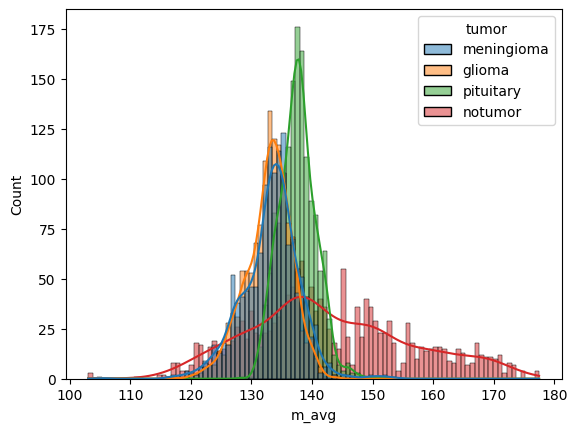

In [72]:
#print(df_train)
sns.histplot(data=df_train, x="m_avg",hue="tumor", kde=True)

Jak widać rozkład cechy zdefiniowanej jako średnia z widma obrazu w przypadku glejaka i oponiaka jest niemalże nierozróżnialny. Dla zdjęć zdrowych można zauważyć dość duży obszar dla średnich powyżej 150, tworzony wyłącznie przez nie. Prawdopodobnie wynika to ze specyfiki obrazów zdrowych. Są one bardziej dynamiczne - miejscami dużo jaśniejsze, bardziej zróżnicowane niż obrazy z pozostałych klas. Rozkład tej cechy dla guzów przysadki mózgowej (pituitary) najbardziej ze wszystkich koncentruje się wokół wartości najczęstszej, pozostałe są odrobinę mniej zwarte a wśród zdrowych przypadków wrecz mocno rozrzucone pod względem czestości występowania. Uprzedzając fakty udział tej cechy w niewielkim stopniu podnosi dokładność klasyfikatora.

In [73]:
df_train.groupby('tumor')['form_factor'].describe()
print(df_train.describe()) 


        threshold0  mean_threshold    background       core_x        core_y  \
count  5712.000000     5712.000000   5712.000000  5712.000000   5712.000000   
mean     47.332432       47.332432  12384.150210    57.015406   1139.911239   
std      17.620484       17.620484   7811.071568    25.861838   1428.039443   
min       9.736328        9.736328      0.000000     0.000000    100.000000   
25%      35.169010       35.169010   5862.750000    44.000000    652.000000   
50%      44.435631       44.435631  10780.000000    55.000000    891.500000   
75%      54.460194       54.460194  17732.000000    66.000000   1249.000000   
max     137.640625      137.640625  51796.000000   214.000000  35776.000000   

             white  form_factor        m_avg  
count  5712.000000  5712.000000  5712.000000  
mean     27.554272     1.701403   136.957301  
std     140.139015     0.388432     8.813476  
min       0.000000     1.019145   103.050538  
25%       0.000000     1.487377   132.442129  
50%   

In [74]:
df_train=df_train[['mean_threshold','background','core_x','core_y','white','form_factor','m_avg','tumor']]
df_test=df_test[['mean_threshold','background','core_x','core_y','white','form_factor','m_avg','tumor']]

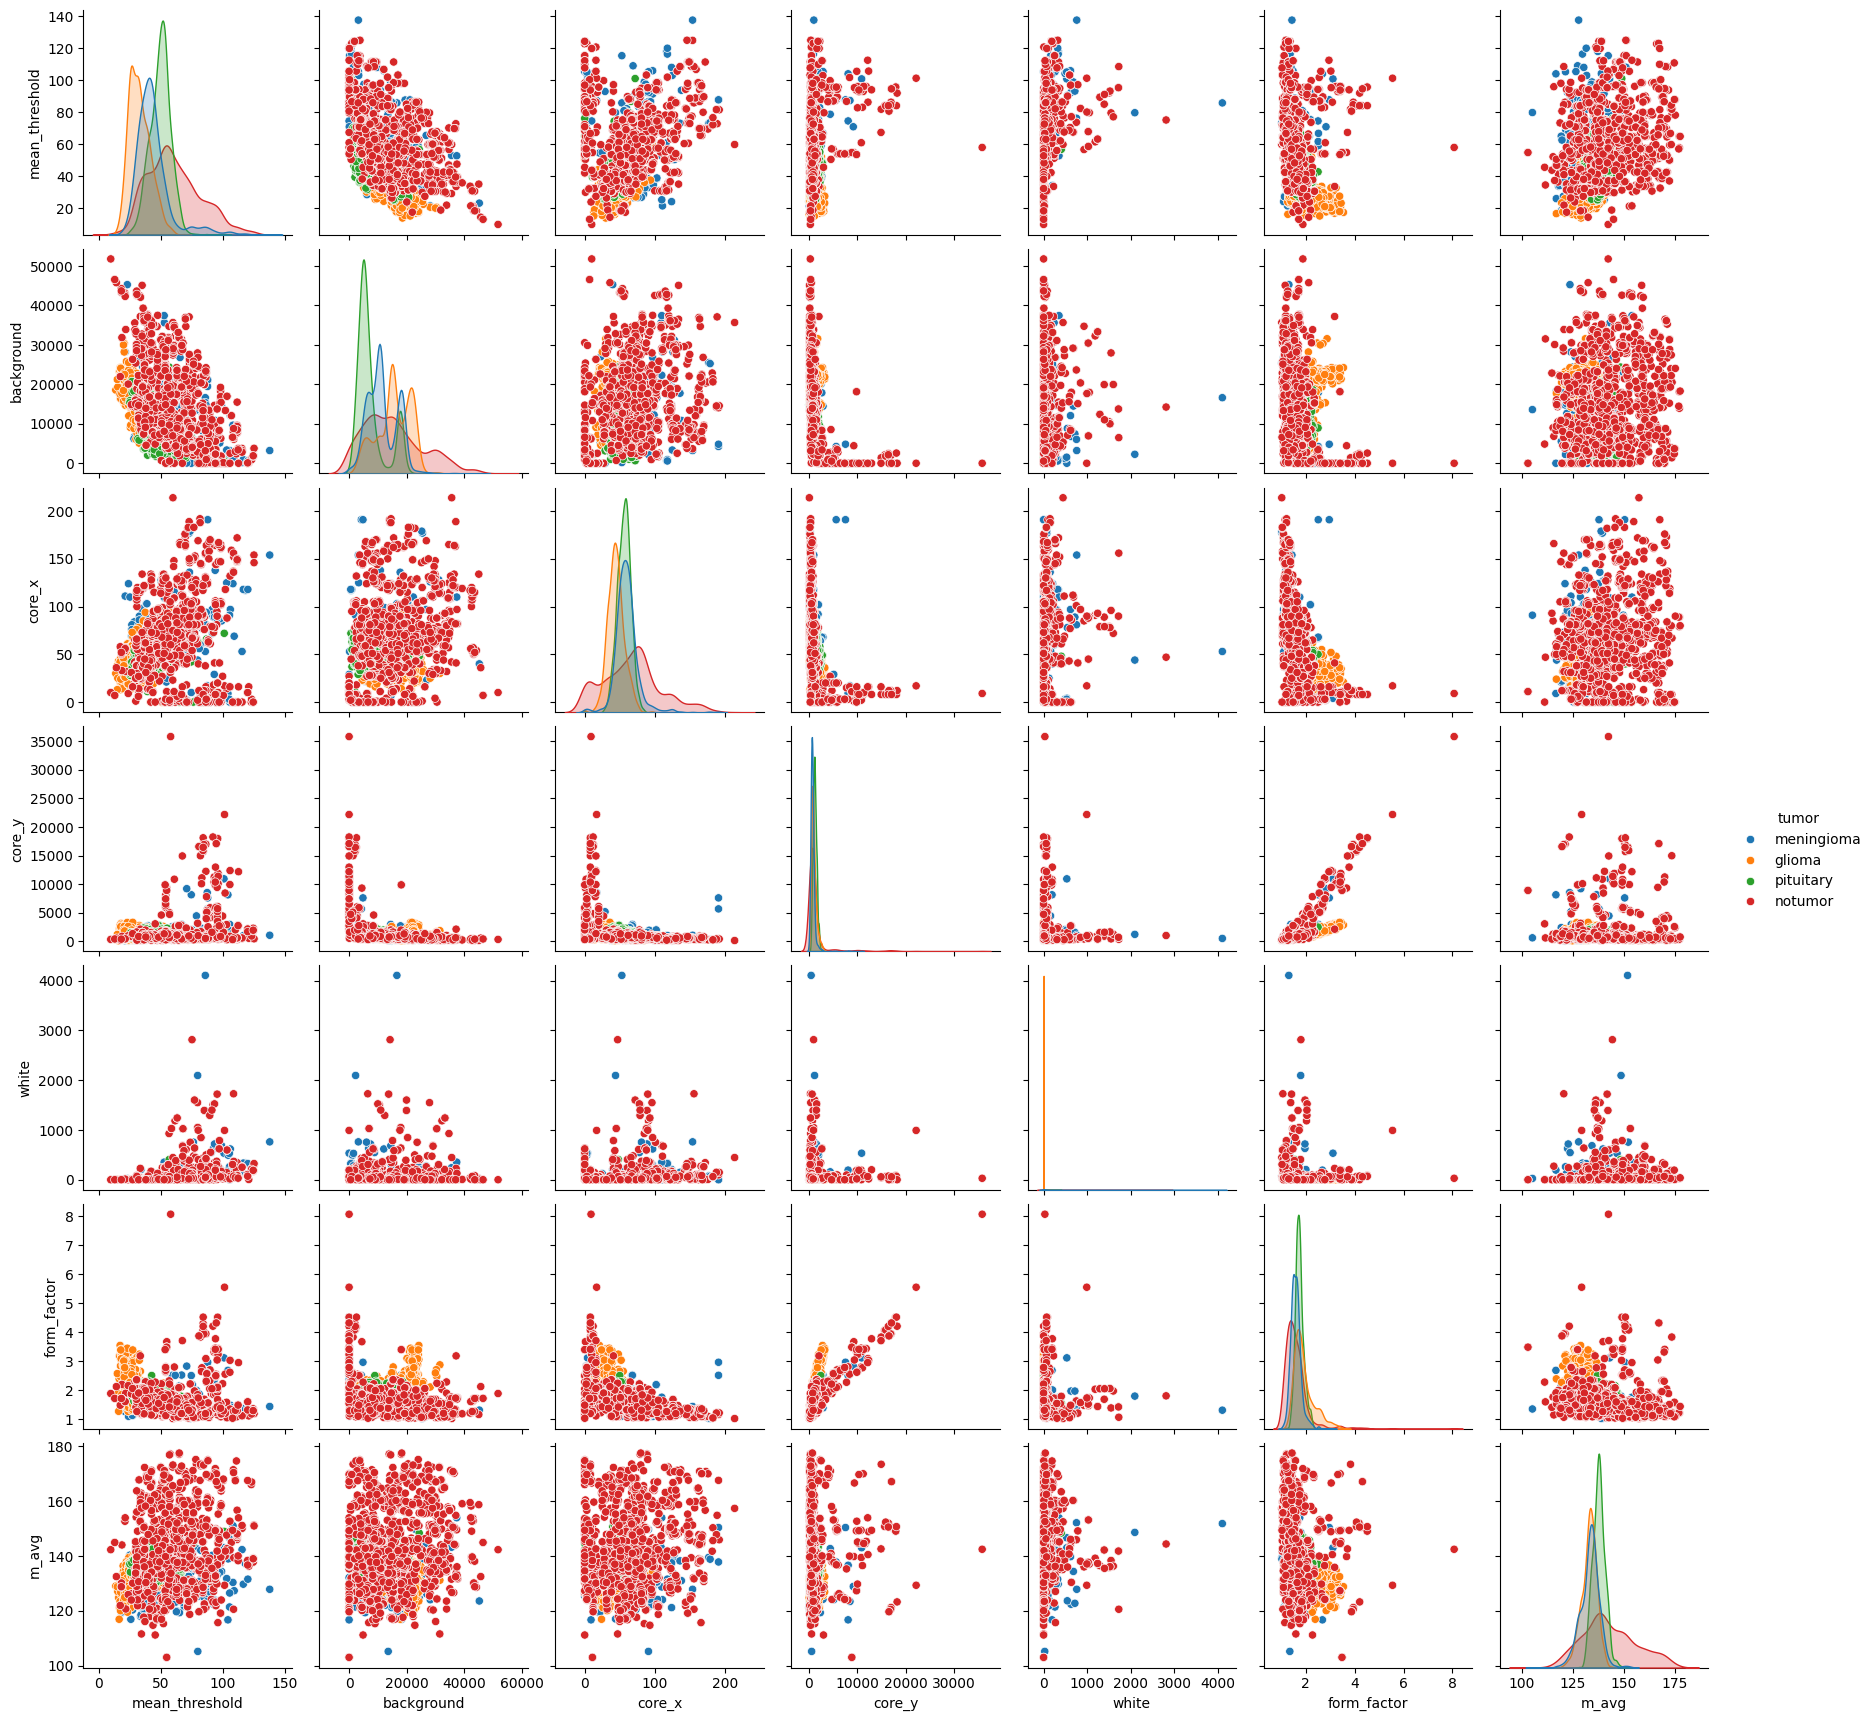

In [75]:
def color_map(tumor_label):
  if tumor_label == 'glioma':
    return 'red'
  elif tumor_label == 'meningioma':
    return 'blue'
  elif tumor_label == 'pituitary':
    return 'orange'
  else:
    return 'green'
colors=df_train["tumor"].map(color_map)
sns.pairplot(df_train.iloc[:,:],hue='tumor')

Rozkład cech we wzajemnej przestrzeni dla wszystkich par zbioru nie pozwala wskazać dwójki atrybutów dla których klasy dawałyby się jednoznacznie rozróżnić. Ich rozkłady są mocno przemieszane z pozostałymi klasami, co nie jest w pełni obserwowalne, gdyż klasa zdrowych przesłania pozostałe. Niektóre pary charakteryzuje duża entropia i szeroka chmura punktów. Inne skupiają sie wzdłuż osi układu współrzędnych.

<Axes: >

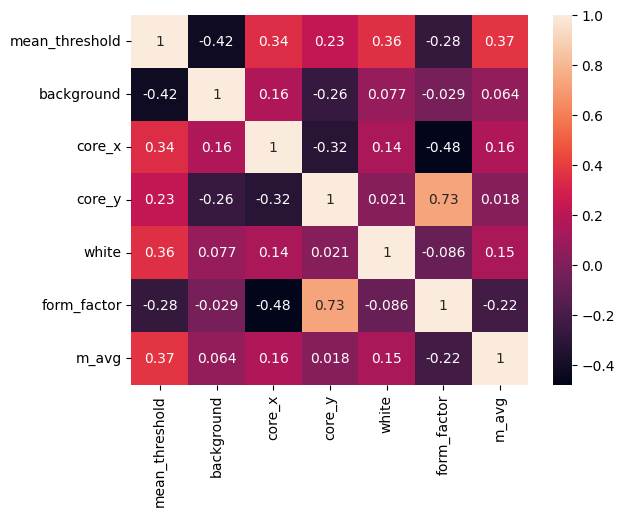

In [76]:
sns.heatmap(df_train.iloc[:,:-1].corr(),annot=df_train.iloc[:,:-1].corr())

Macierz korelacji cech nie wskazuje jednoznacznie na redundancje i zbędne cechy. Najmocniejsza korelacja występuje pomiędzy cechą współczynnika kształtu a wartoscią szczytową drugiego prążka. Moim zdaniem korelacja ta nie jest na tyle duża aby rezygnować z którejkolwiek z tych cech w procesie uczenia. Pozostałe korelacje również są akceptowalne w kontekście zbędności atrybutów. 

### Modele klasyfikujące korzystające z wyekstrahowanych cech

In [77]:
def verify(model,data,atrib):
    # prints classifier results as confusion matrix
    # for test and training set
    # model - classifier model
    # data - data (dictionary returned by divide function)
    # atrib - list of attributes' indexes considered in verification
    model.fit(data["opis_ucz"].iloc[:,atrib], data["dec_ucz"])
    result_train = model.predict(data["opis_ucz"].iloc[:,atrib])
    result_test = model.predict(data["opis_test"].iloc[:,atrib])
    cm_train = confusion_matrix(data["dec_ucz"],result_train)
    print("macierz pomyłek - zbiór uczący, dokładność:",np.sum(np.diag(cm_train))/np.sum(cm_train))
    print(model.score(data['opis_ucz'].iloc[:,atrib],data['dec_ucz']))
    print(cm_train)
    cm_test = confusion_matrix(data["dec_test"],result_test)
    print("macierz pomyłek - zbiór testowy, dokładność:",np.sum(np.diag(cm_test))/np.sum(cm_test))
    print(model.score(data['opis_test'].iloc[:,atrib],data['dec_test']))
    print(cm_test)
    return cm_train,cm_test

In [78]:
def errorChart(error_data,xlabel,ylabel):
    plt.figure(dpi=90)
    plt.plot(np.arange(1, len(error_data)+1), error_data,'bo-')
    plt.title('Wykres błędu')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [79]:
def prepare_to_classifier(df_training,df_validation):
  return {"opis_ucz":df_training.iloc[:,:-1], "opis_test":df_validation.iloc[:,:-1], "dec_ucz":df_train.iloc[:,-1], "dec_test":df_test.iloc[:,-1]}

macierz pomyłek - zbiór uczący, dokładność: 1.0
1.0
[[1321    0    0    0]
 [   0 1339    0    0]
 [   0    0 1595    0]
 [   0    0    0 1457]]
macierz pomyłek - zbiór testowy, dokładność: 0.7200610221205187
0.7200610221205187
[[169  68  24  39]
 [ 29 217  25  35]
 [ 16  24 343  22]
 [ 34  35  16 215]]
macierz pomyłek - zbiór uczący, dokładność: 0.8370098039215687
0.8370098039215687
[[1321    0    0    0]
 [ 229 1110    0    0]
 [ 136  152 1307    0]
 [ 140  209   65 1043]]
macierz pomyłek - zbiór testowy, dokładność: 0.658276125095347
0.658276125095347
[[198  66  16  20]
 [ 74 195  21  16]
 [ 48  48 300   9]
 [ 53  57  20 170]]
macierz pomyłek - zbiór uczący, dokładność: 0.8042717086834734
0.8042717086834734
[[1036  139   66   80]
 [ 168  983   80  108]
 [ 124   84 1340   47]
 [  95   94   33 1235]]
macierz pomyłek - zbiór testowy, dokładność: 0.6613272311212814
0.6613272311212814
[[177  65  24  34]
 [ 53 157  62  34]
 [ 41  26 317  21]
 [ 37  34  13 216]]
macierz pomyłek - zbiór ucz

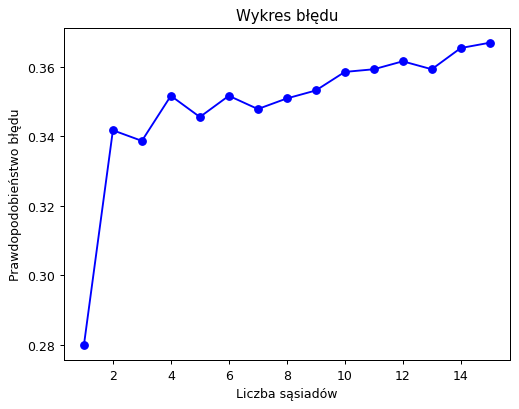

In [80]:
data=prepare_to_classifier(df_train,df_test)
rss_all=np.zeros(15)
#print(df_test)
for k in range(1,16):
    model= KNeighborsClassifier(n_neighbors=k)
    matrix= verify(model,data,[0,1,2,3,4,5,6])
    rss_all[k-1] = 1-model.score(data["opis_test"],data["dec_test"])
    '''
    plt.figure(figsize=(16,6),dpi=100)
    plt.subplot(1,2,1)
    sns.heatmap(matrix[0],annot=matrix[0],fmt="d")
    plt.title("Macierz pomyłek dla zbioru uczącego")
    plt.subplot(1,2,2)
    sns.heatmap(matrix[1],annot=matrix[1],annot_kws={"size": 10})
    plt.title("Macierz pomyłek dla zbioru testowego")
    plt.suptitle("K="+str(k))
    '''
errorChart(rss_all,"Liczba sąsiadów","Prawdopodobieństwo błędu")

Klasyfikator najbliższego sąsiada daje największą skuteczność dla liczby sąsiadów równej 1, co jest dosć nieintuicyjne moim zdaniem, zwykle to zwięksenie liczby sąsiadów poprawia jego skuteczność. Najwidoczniej w przestrzeni cech kształtuje się dość nietypowy rozkład.

macierz pomyłek - zbiór uczący, dokładność: 0.4487044817927171
0.4487044817927171
[[   0    0   12 1309]
 [   0    0  138 1201]
 [   0    0 1118  477]
 [   0    0   12 1445]]
macierz pomyłek - zbiór testowy, dokładność: 0.43173150266971777
0.43173150266971777
[[  0   0   4 296]
 [  0   0 102 204]
 [  0   0 267 138]
 [  0   0   1 299]]
macierz pomyłek - zbiór uczący, dokładność: 0.5884103641456583
0.5884103641456583
[[1120    0   12  189]
 [ 851    0  138  350]
 [ 357    0 1118  120]
 [ 322    0   12 1123]]
macierz pomyłek - zbiór testowy, dokładność: 0.5484363081617086
0.5484363081617086
[[246   0   4  50]
 [141   0 102  63]
 [107   0 267  31]
 [ 93   0   1 206]]
macierz pomyłek - zbiór uczący, dokładność: 0.6596638655462185
0.6596638655462185
[[ 795  409    7  110]
 [ 160  957  113  109]
 [ 137  285 1104   69]
 [ 112  424    9  912]]
macierz pomyłek - zbiór testowy, dokładność: 0.5743707093821511
0.5743707093821511
[[158 110   1  31]
 [ 31 161  90  24]
 [ 34  87 264  20]
 [ 30 100   0

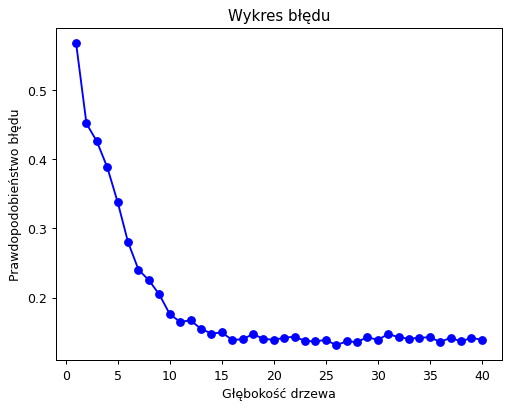

In [81]:
data = prepare_to_classifier(df_train,df_test)
rss_tree=np.zeros(40)
tree_model=tree.DecisionTreeClassifier(max_depth=1)
for i in range (1,41):
    tree_model= tree.DecisionTreeClassifier(max_depth=i)
    matrix=verify(tree_model,data,[0,1,2,3,4,5,6])
    rss_tree[i-1]=1-tree_model.score(data["opis_test"].iloc[:,[0,1,2,3,4,5,6]],data["dec_test"])
    #plt.figure(figsize=(16,6),dpi=100)
    #plt.subplot(1,2,1)
    #sns.heatmap(matrix[0],annot=matrix[0],fmt="3d")
    #plt.title("Macierz pomyłek dla zbioru uczącego")
    #plt.subplot(1,2,2)
    #sns.heatmap(matrix[1],annot=matrix[1],fmt="3d")
    #plt.title("Macierz pomyłek dla zbioru testowego")
    #plt.suptitle("Depth= "+str(i))
errorChart(rss_tree,"Głębokość drzewa", "Prawdopodobieństwo błędu")

Wykres błędu dla różnych głębokości drzewa ma charakter malejący. W myśl zasady łokciowej można wskazać optymalną głębokość równą 12-14. Większe głębokości dają niewiele większą skuteczność, lecz przy większych głębokościach rośnie złożoność obliczniowa pojedynczej decyzji oraz ryzyko przeuczenia.

macierz pomyłek - zbiór uczący, dokładność: 0.5169817927170869
0.5169817927170869
[[1210    3    1  107]
 [ 925   35   88  291]
 [ 304  367  695  229]
 [ 438    1    5 1013]]
macierz pomyłek - zbiór testowy, dokładność: 0.4973302822273074
0.4973302822273074
[[272   0   0  28]
 [153  22  69  62]
 [ 96  83 186  40]
 [127   0   1 172]]


Text(0.5, 1.0, 'Macierz pomyłek dla zbioru testowego')

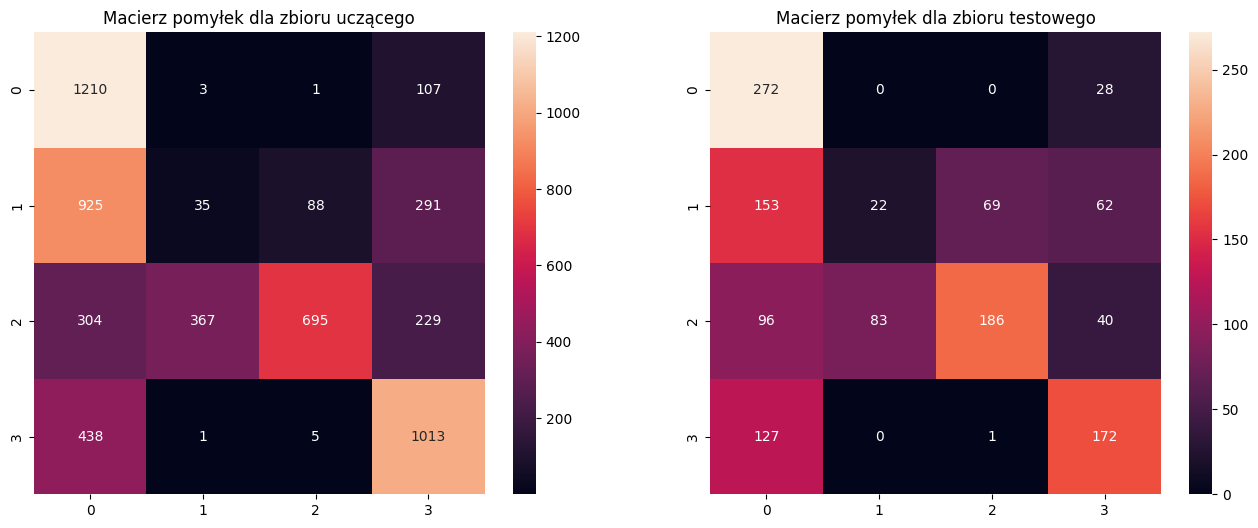

In [82]:
data = prepare_to_classifier(df_train,df_test)
model= GaussianNB()
matrix=verify(model,data,[0,1,2,3,4,5])
plt.figure(figsize=(16,6),dpi=100)
plt.subplot(1,2,1)
sns.heatmap(matrix[0],annot=matrix[0],fmt='d')
plt.title("Macierz pomyłek dla zbioru uczącego")
plt.subplot(1,2,2)
sns.heatmap(matrix[1],annot=matrix[1],fmt='d')
plt.title("Macierz pomyłek dla zbioru testowego")


Przedstawiony tu naiwny klasyfikator Bayesa daje nieakceptowalnie niską skuteczność. Jest wyższa od losowej, ale zdecydowanie za mała. Ten klasyfikator reprezentuje grupę przetestowanych klasyfikatorów, które nie radzą sobie ze zbiorem. Nie do końca wiem dlaczego. Wydaje mi się, że wielowymiarowa przestrzeń cech i zbiór występującej w niej punktów jest zbyt złożony, wiele parametrów być może jest potraktowane zbyt ogólnie, wyznaczenie dla nich reguł też może być wyzwaniem.

In [83]:
model=Sequential(
    [
        Dense(64,activation='tanh',input_shape=(7,)),
        Dense(32,activation='tanh'),
        Dense(4,activation='softmax')
    ]
)
model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001),metrics =['accuracy'])

/home/asus/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [84]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,724 (10.64 KB)

 Trainable params: 2,724 (10.64 KB)

 Non-trainable params: 0 (0.00 B)

In [85]:
def encode_labels(label):
    if label=='glioma':
        return 0.0
    elif label=='meningioma':
        return 1.0
    elif label=='notumor':
        return 2.0
    elif label=='pituitary':
        return 3.0
df_train["tumor"]=df_train["tumor"].map(encode_labels)
df_test["tumor"]=df_test["tumor"].map(encode_labels)

In [86]:
#normalization
df_train[['mean_threshold','background','core_x','core_y','white','form_factor','m_avg']]=df_train.iloc[:,:-1].apply(lambda x:(x-x.mean())/x.std())
df_test[['mean_threshold','background','core_x','core_y','white','form_factor','m_avg']]=df_test.iloc[:,:-1].apply(lambda x:(x-x.mean())/x.std())

In [87]:
history=model.fit(
   x= df_train.iloc[:,:-1],
    y=df_train.iloc[:,-1],
    validation_data=(df_test.iloc[:,:-1],df_test.iloc[:,-1]),
    epochs=200
)

Epoch 1/200
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5722 - loss: 1.0700 - val_accuracy: 0.6171 - val_loss: 0.9826
Epoch 2/200
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7164 - loss: 0.7761 - val_accuracy: 0.6369 - val_loss: 0.9493
Epoch 3/200
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7235 - loss: 0.7325 - val_accuracy: 0.6697 - val_loss: 0.8989
Epoch 4/200
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7419 - loss: 0.7024 - val_accuracy: 0.6705 - val_loss: 0.8669
Epoch 5/200
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7436 - loss: 0.6930 - val_accuracy: 0.6796 - val_loss: 0.8384
Epoch 6/200
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7490 - loss: 0.6728 - val_accuracy: 0.6705 - val_loss: 0.8274
Epoch 7/200
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7493 - loss: 0.6566 - val_accuracy: 0.6888 - val_loss: 0.8016
Epoch 8/200
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7668 - loss: 0.6350 - val_accu

Text(0.5, 0, 'epoka uczenia')

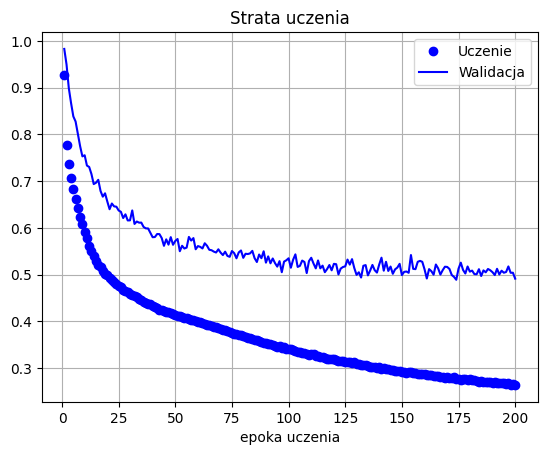

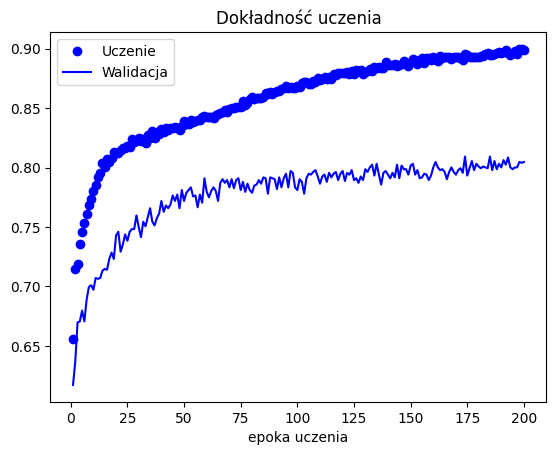

In [88]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.grid(True)
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'bo', label='Uczenie')
plt.plot(epochs, val_loss, 'b', label='Walidacja')
plt.title("Strata uczenia")
plt.legend()
plt.xlabel("epoka uczenia")
plt.figure()
plt.plot(epochs, acc, 'bo', label='Uczenie')
plt.plot(epochs, val_acc, 'b', label='Walidacja')
plt.title("Dokładność uczenia")
plt.legend()
plt.xlabel("epoka uczenia")

Tak opracowany model uzyskuje dokładność na zbiorze testowym około 80%. Od około setnej epoki strata i dokładność na zbiorze testowym zaczyna się stabilizować.

<hr><br>
Podsumowując najskuteczniejszym modelem okazało się tutaj drzewo decyzyjne o skuteczności ponad 85%. Niewiele bardziej zawodna była sieć neuronowa o  2 724 parametrach, złożona z 3 warstw gęsto połączonych z jedną warstwą ukrytą. Jej skuteczność wyniosła około 80%. Klasyfikator najbliższego sąsiada dał skuteczność na poziomie 72%. Pozostałe modele okazały się bezradne wobec problemu.